In [1]:

from autocvd import autocvd
autocvd(num_gpus = 3)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding
jax.config.update("jax_enable_x64", True)


import numpy as np
from astropy import units as u

from odisseo import construct_initial_state
from odisseo.dynamics import DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams
from odisseo.option_classes import MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from odisseo.initial_condition import Plummer_sphere
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.utils import projection_on_GD1

#import flowjax, use for the loss function
from flowjax.bijections import RationalQuadraticSpline
from flowjax.distributions import Normal
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_data

#optimization
from jaxopt import ScipyMinimize, LBFGS
import optax

from chainconsumer import Chain, ChainConsumer, Truth, make_sample
import pandas as pd


import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

# Generate the target simulation 

(-250.0, 250.0)

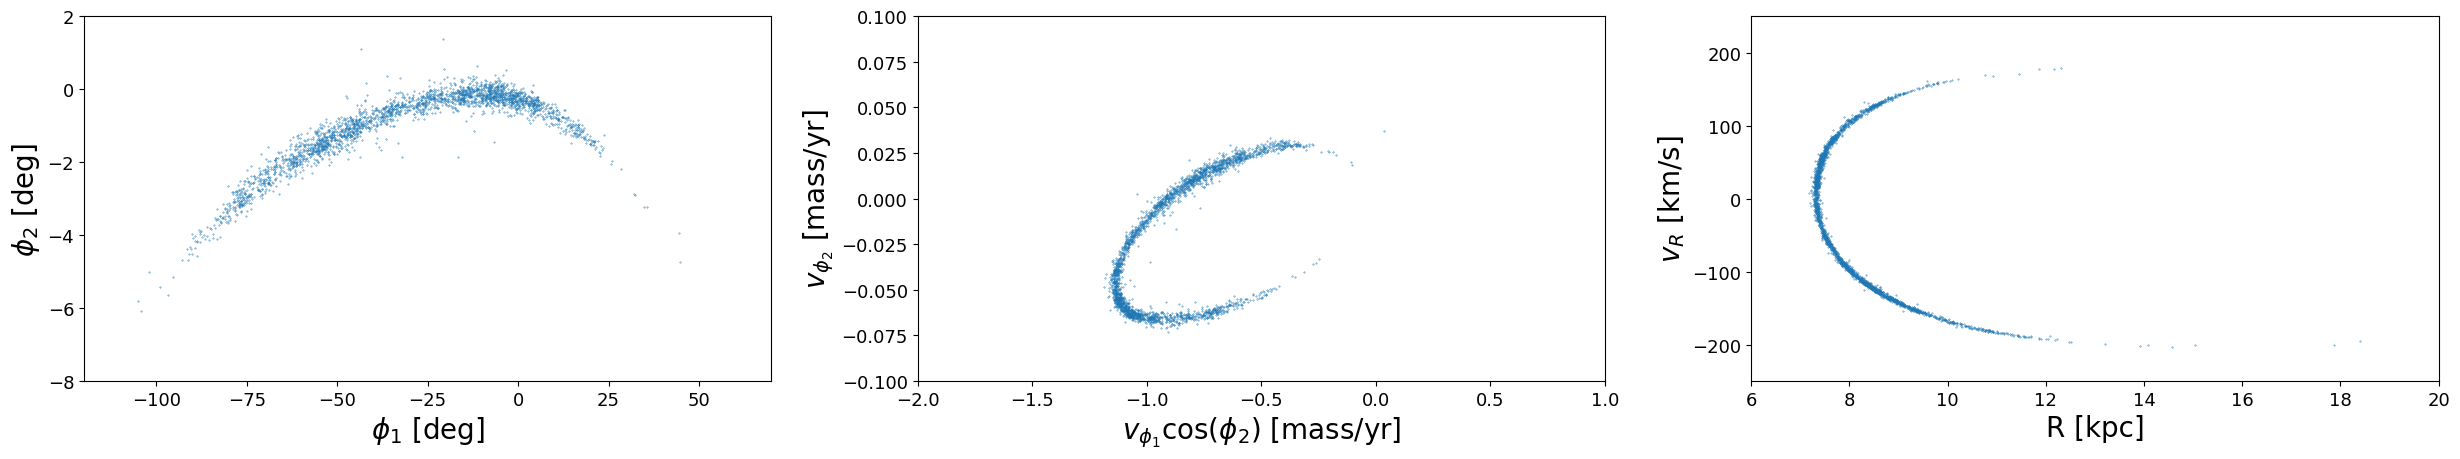

In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  

#set the config, we cannot differentiate with respect to the config
config = SimulationConfig(N_particles = 2_500, 
                          return_snapshots = False, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,) #default values

# set the simulation parameters, we can differentiate with respect to these parameters
params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 

#the center of mass has the same config and params as the main simulation but it needs to be integrated backwards in time 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#random key for JAX
key = random.PRNGKey(1)
#Final position and velocity of the center of mass
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
mass_com = jnp.array([params.Plummer_params.Mtot]) 

#we construmt the initial state of the com 
initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
#we run the simulation backwards in time for the center of mass
final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=params_com)
#we calculate the final position and velocity of the center of mass
pos_com = final_state_com[:, 0]
vel_com = final_state_com[:, 1]

#we construct the initial state of the Plummer sphere
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)
#we add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com
#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities, )
#run the simulation
final_state = time_integration(initial_state_stream, mass, config=config, params=params)

#projection on the GD1 stream
stream = projection_on_GD1(final_state, code_units=code_units,)

#plot to check the stream
R = stream[:, 0]  # kpc
phi1 = stream[:, 1]  # deg
phi2 = stream[:, 2]  # deg
vR = stream[:, 3]  # km/s
v1_cosphi2 = stream[:, 4]  # mass/yr
v2 = stream[:, 5]  # mass/yr

fig = plt.figure(figsize=(25, 5), tight_layout=True)

ax = fig.add_subplot(131)
ax.scatter(phi1, phi2, s=0.1)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)

ax = fig.add_subplot(132)
ax.scatter(v1_cosphi2 ,
           v2 ,
            s=0.1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mass/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mass/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)

ax = fig.add_subplot(133)
ax.scatter(R, vR , s=0.1)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)


# Add observational noise

This is fully differentiable and jittable, exept for the training, since in the training a varying size array is passed.
In theory its possible to remove this part, but the number of stars is quite large when concatanted with the the selected stream, 
so the training is very long and it would require to change the NaN values with something outside of the observational window and
using a constrained Normalizing Flow (https://danielward27.github.io/flowjax/examples/constrained.html)

 12%|█▏        | 12/100 [00:11<01:21,  1.08it/s, train=0.897, val=1.17 (Max patience reached)]


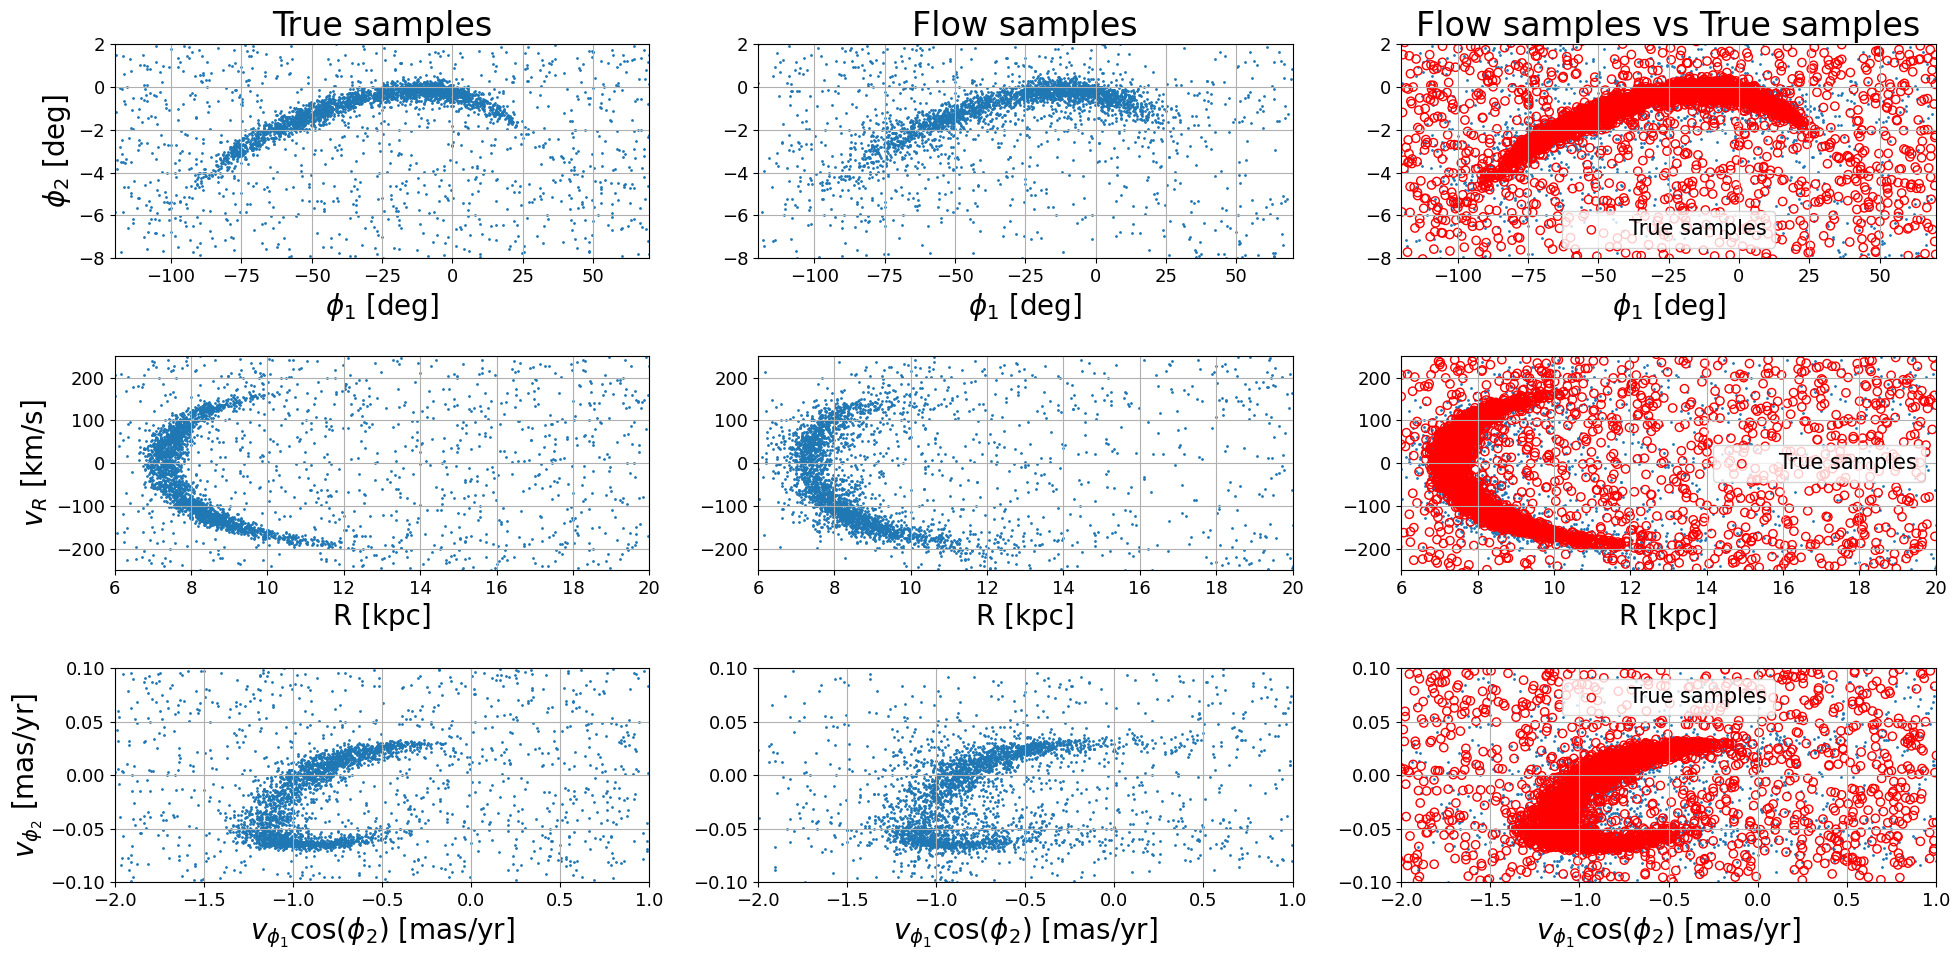

In [3]:
#Bimodal sampling
@jit
def selection_function(stream_star, p, key):
    # Apply selection criteria
    return jnp.where(jax.random.uniform(key=key, shape=1) < p, stream_star, jnp.nan)

# Generate a random background star position
@jit 
def background_assignement(key):
    return jax.random.uniform(key=key, shape=(6,),
                              minval=jnp.array([6, -120, -8, -250, -2., -0.10]),
                             maxval=jnp.array([20, 70, 2, 250, 1.0, 0.10]))

# Select stars from the stream based on Bimodal sampling
key = random.PRNGKey(42)
keys = random.split(key, stream.shape[0])
p = jnp.ones(shape=(stream.shape[0]))* 0.95
selected_stream = jax.vmap(selection_function, )(stream, p, keys)

# Nbackground star contamination
N_background = int(1e6)
#Generate the probability of selectin a background star
background_selected_probability = jnp.where(jax.random.uniform(key=key, shape=(N_background,)) < 1e-3, 1.0, 0.0)
keys = random.split(key, N_background)
selected_background = jax.vmap(lambda key, background_star_probability: jnp.where(background_star_probability, background_assignement(key), jnp.nan))(keys, background_selected_probability)

# Combine the selected stream and background stars
stream = jnp.concatenate((selected_stream, selected_background), axis=0)

#add gaussian noise to the stream, same as in Albatross paper (https://arxiv.org/pdf/2304.02032)
noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
stream = stream + jax.random.normal(key=jax.random.key(0), shape=stream.shape) * noise_std

stream_mean = jnp.nanmean(stream, axis=0)
stream_std = jnp.nanstd(stream, axis=0)
stream = (stream - stream_mean) / stream_std  # Standardize the data

stream_target = stream[~jnp.isnan(stream)].reshape(-1, 6)  # Remove NaN values for training

# Assign a new out of the observational windows value to the NaN values, and use constrain support NF, not implemented yet
# stream = jax.vmap(lambda stream_star: jnp.where(jnp.isnan(stream_star), jnp.ones((6))*100, stream_star))(stream)

#rng
rng = jax.random.key(0)

# create the flow
subkey, rng = jax.random.split(rng)
flow = masked_autoregressive_flow(
    subkey,
    base_dist=Normal(jnp.zeros(stream.shape[1])),
    transformer=RationalQuadraticSpline(knots=8, interval=4),
)

#we train only on the non NaN values of the stream
key, subkey = jax.random.split(key)
flow, losses = fit_to_data(subkey, flow, stream[~jnp.isnan(stream)].reshape(-1, 6), learning_rate=1e-3)


# Check the flow sampling
stream_plot = stream[~jnp.isnan(stream)].reshape(-1, 6) * stream_std + stream_mean
key, subkey = jax.random.split(jax.random.key(1))
x_samples = flow.sample(subkey, (stream_plot.shape[0],))

# Transform the samples back to the original scale
x_samples_plot = x_samples * stream_std + stream_mean

fig = plt.figure(figsize=(20, 10), tight_layout=True)
ax = fig.add_subplot(331)
ax.scatter(stream_plot[:, 1], stream_plot[:, 2], s=1 )
ax.set_title("True samples")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.grid('dotted')
ax = fig.add_subplot(332)
ax.scatter(x_samples_plot[:, 1], x_samples_plot[:, 2], s=1)
ax.set_title("Flow samples")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
ax.set_xlabel("$\phi_1$ [deg]")
ax.grid('dotted')
ax = fig.add_subplot(333)
ax.set_title("Flow samples vs True samples")
ax.scatter(x_samples_plot[:, 1], x_samples_plot[:, 2], s=1)
ax.scatter(stream_plot[:, 1], stream_plot[:, 2],  marker='o', facecolors='none',  color='r', label='True samples')
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
ax.legend()
ax.set_xlabel("$\phi_1$ [deg]")
ax.grid('dotted')

ax = fig.add_subplot(334)
ax.scatter(stream_plot[:, 0], stream_plot[:, 3],s=1 )
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
ax.grid('dotted')
ax = fig.add_subplot(335)
ax.scatter(x_samples_plot[:, 0], x_samples_plot[:, 3], s=1)
ax.set_xlabel("R [kpc]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
ax.grid('dotted')
ax = fig.add_subplot(336)
ax.scatter(x_samples_plot[:, 0], x_samples_plot[:, 3], s=1)
ax.scatter(stream_plot[:, 0], stream_plot[:, 3], marker='o', facecolors='none', color='r', label='True samples')
ax.set_xlabel("R [kpc]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
ax.legend()
ax.grid('dotted')

ax = fig.add_subplot(337)
ax.scatter(stream_plot[:, 4], stream_plot[:, 5], s=1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mas/yr]")      
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
ax.grid('dotted')
ax = fig.add_subplot(338)
ax.scatter(x_samples_plot[:, 4], x_samples_plot[:, 5], s=1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
ax.grid('dotted')
ax = fig.add_subplot(339)
ax.scatter(x_samples_plot[:, 4], x_samples_plot[:, 5], s=1)
ax.scatter(stream_plot[:, 4], stream_plot[:, 5], marker='o', facecolors='none', color='r', label='True samples')
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
ax.grid('dotted')
ax.legend()
plt.tight_layout()


# Differentiable Loss and optimization

## Loss for a single parameter NFW Mass

In [4]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def time_integration_NFW_mass_grad(Mvir, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)
    key_Plummer, key_selection, key_background, key_noise = random.split(key, 4)
    
    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key_Plummer, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)

    #Stream selection success
    keys_selection = random.split(key_selection, stream.shape[0])
    p = jnp.ones(shape=(stream.shape[0]))* 0.95
    selected_stream = jax.vmap(selection_function, )(stream, p, keys_selection)

    # #background contamination
    N_background = int(1e6)
    # #Generate the probability of selectin a background star, this is computationally expensive, so we just add 1_000 background stars
    # background_selected = jnp.where(jax.random.uniform(key=key_background, shape=(N_background,)) < 1e-3, 1.0, 0.0)
    # keys_background = random.split(key_background, N_background)
    # selected_background = jax.vmap(lambda key, background_star: jnp.where(background_star, background_assignement(key), jnp.nan))(keys_background, background_selected)
    N_background = int(N_background * 1e-3)
    selected_background = jax.vmap(background_assignement, )(random.split(key=key_background, num=N_background))

    # Combine the selected stream and background stars
    stream = jnp.concatenate((selected_stream, selected_background), axis=0)

    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
    stream = stream + jax.random.normal(key=key_noise, shape=stream.shape) * noise_std
    #we calculate the loss as the negative log likelihood of the stream
    log_prob = eqx.filter_jit(flow.log_prob)((stream-stream_mean)/stream_std)  # Subtract the mean and divde by the std for normalization

    loss = - jnp.sum( jnp.where( jnp.isinf(log_prob), 0., log_prob  )  ) #if the NaN value are passed the value of the log_prob is -inf, we set it to 0 to not contribute to the loss

    return loss


In [5]:
# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = params.NFW_params.Mvir*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_NFW_mass_grad, )(Mvir, key)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  

2025-06-09 14:52:04.880060: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3022] Can't reduce memory use below 9.56GiB (10264803979 bytes) by rematerialization; only reduced to 21.19GiB (22754789349 bytes), down from 21.19GiB (22755149493 bytes) originally


Gradient of the total mass of the Mvir of NFW:
 -0.008854047340448257
Loss:
 13357.534901400739


## Loss for all the parameters

In [4]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))



@jit
def time_integration_fix_position_grad(t_end, 
                                       M_plummer,
                                       a_plummer,
                                       M_NFW,
                                       r_s_NFW,
                                       M_MN,
                                       a_MN,
                                       key):

    #Creation of the Plummer sphere requires a key 
    # key = random.PRNGKey(key)
    key_Plummer, key_selection, key_background, key_noise = random.split(key, 4)
    
    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    #parameters of the stream
    new_params = params._replace(
                t_end = t_end,
                Plummer_params=params.Plummer_params._replace(
                    Mtot=M_plummer,
                    a=a_plummer
                ),
                NFW_params=params.NFW_params._replace(
                    Mvir=M_NFW,
                    r_s=r_s_NFW
                ),
                MN_params=params.MN_params._replace(
                    M=M_MN,
                    a=a_MN
                ))
    #parameters of the center of mass
    #we set the t_end to be negative, so we run the simulation backwards in time
    new_params_com = new_params._replace(t_end=-t_end,)

    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key_Plummer, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)

    #Stream selection success
    keys_selection = random.split(key_selection, stream.shape[0])
    p = jnp.ones(shape=(stream.shape[0]))* 0.95
    # selected_stream = jax.vmap(selection_function, )(stream, p, keys_selection)
    selected_stream = stream

    # #background contamination
    N_background = int(1e6)
    # #Generate the probability of selectin a background star, this is computationally expensive, so we just add 1_000 background stars
    # background_selected = jnp.where(jax.random.uniform(key=key_background, shape=(N_background,)) < 1e-3, 1.0, 0.0)
    # keys_background = random.split(key_background, N_background)
    # selected_background = jax.vmap(lambda key, background_star: jnp.where(background_star, background_assignement(key), jnp.nan))(keys_background, background_selected)
    N_background = int(N_background * 1e-3)
    selected_background = jax.vmap(background_assignement, )(random.split(key=key_background, num=N_background))

    # Combine the selected stream and background stars
    stream = jnp.concatenate((selected_stream, selected_background), axis=0)

    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
    stream = stream + jax.random.normal(key=key_noise, shape=stream.shape) * noise_std
    #we calculate the loss as the negative log likelihood of the stream

    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    def normalize_stream(stream):
        # Normalize each dimension to [0,1]
        return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    sim_norm = normalize_stream(stream)
    target_norm = normalize_stream(stream_target)
    
    # Adaptive bandwidth for 6D data
    n_sim, n_target = len(stream), len(stream_target)
    sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D

    
    # Compute MMD terms
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(target_norm))(sim_norm))


    return xx + yy - 2 * xy
    



In [5]:
# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
t_end = params.t_end * (3/4)
M_plummer = params.Plummer_params.Mtot * (3/4)
Mvir = params.NFW_params.Mvir * (3/4)
r_s_NFW = params.NFW_params.r_s * (3/4)
a_plummer = params.Plummer_params.a * (3/4)
M_MN = params.MN_params.M * (3/4)
a_MN = params.MN_params.a * (3/4)

key = random.PRNGKey(0)
loss, grad = jax.value_and_grad(time_integration_fix_position_grad, 
                                argnums=(0, 1, 2, 3, 4, 5, 6) )(t_end,
                                                                M_plummer,
                                                                a_plummer,
                                                                Mvir,
                                                                r_s_NFW,
                                                                M_MN,
                                                                a_MN,
                                                                key)
# Print the results
print("Gradient of the simulations wrt to initial parameter \n", grad)
print("Loss:\n", loss)  

2025-06-13 08:50:49.796667: E external/xla/xla/service/gpu/gpu_hlo_schedule.cc:654] The byte size of input/output arguments (12107021996) exceeds the base limit (8654290944). This indicates an error in the calculation!
2025-06-13 08:50:50.196498: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3022] Can't reduce memory use below 0B (0 bytes) by rematerialization; only reduced to 12.04GiB (12930236469 bytes), down from 12.04GiB (12930416757 bytes) originally
2025-06-13 08:51:05.737776: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 57.22MiB (rounded to 60000000)requested by op 
2025-06-13 08:51:05.738232: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] ****************************************************************************************************
E0613 08:51:05.738266 2583242 pjrt_stream_executor_client.cc:2917] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while tryi

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 60000000 bytes.

# jaxopt ScipyMinimize

In [6]:
@jit
def time_integration_fix_position_grad_ScipyMinimize(param, key):
    t_end, M_plummer, a_plummer, Mvir, r_s_NFW, M_MN, a_MN = param
    return time_integration_fix_position_grad(t_end, 
                                              M_plummer,
                                              a_plummer,
                                              Mvir,
                                              r_s_NFW,
                                              M_MN,
                                              a_MN,
                                              key)

optimizer = ScipyMinimize(
     method="l-bfgs-b", 
     dtype=jnp.float64,
     fun=time_integration_fix_position_grad_ScipyMinimize, 
     tol=1e-8, 
    )


In [15]:
key = random.PRNGKey(42)
init_params = (t_end * (5/4),
    M_plummer * (5/4),
    a_plummer * (5/4),
    Mvir * (5/4),
    r_s_NFW * (5/4), 
    M_MN * (5/4),
    a_MN * (5/4))

#optimizer jit itself
sol = optimizer.run(
    init_params=init_params,
    key=key)

print("Optimized parameters:", sol.params)
print("Optimized loss:", sol.state.fun_val)

(Array(0.9375, dtype=float64), Array(1.0518923, dtype=float64), Array(0.00075, dtype=float64), Array(40953117.1875, dtype=float64), Array(1.5, dtype=float64), Array(6393178.38584501, dtype=float64), Array(0.28125, dtype=float64))
Optimized parameters: (Array(0.9375, dtype=float64), Array(1.0518923, dtype=float64), Array(0.00075, dtype=float64), Array(40953117.1875, dtype=float64), Array(1.5, dtype=float64), Array(6393178.38584501, dtype=float64), Array(0.28125, dtype=float64))
Optimized loss: -2602.8588071909617


In [ ]:
parameter_value = jax.random.uniform(key=key, 
                                    shape=(2, 7), 
                                    minval=jnp.array([0.5 * u.Gyr.to(code_units.code_time), # t_end in Gyr
                                                    10**3.0 * u.Msun.to(code_units.code_mass), # Plummer mass
                                                    params.Plummer_params.a*(1/4),
                                                    params.NFW_params.Mvir*(1/4),
                                                    params.NFW_params.r_s*(1/4), 
                                                    params.MN_params.M*(1/4), 
                                                    params.MN_params.a*(1/4),]), 
                                                    
                                    maxval=jnp.array([5 * u.Gyr.to(code_units.code_time), # t_end in Gyr
                                                    10**4.5 * u.Msun.to(code_units.code_mass), #Plummer mass
                                                    params.Plummer_params.a*(8/4),
                                                    params.NFW_params.Mvir*(8/4), 
                                                    params.NFW_params.r_s*(8/4), 
                                                    params.MN_params.M*(8/4), 
                                                    params.MN_params.a*(8/4),])) 


In [ ]:
## cannot be used with vmap ! It cast to numpy array
# solutions = jax.vmap(lambda init_params, key: optimizer.run(init_params=init_params, key=key) )(parameter_value, random.split(key, parameter_value.shape[0]))

# We need to sample using for loop because of ScipyMinimize
solutions = [  optimizer.run(init_params=init_params, key=key) for init_params, key in zip(parameter_value, random.split(key, parameter_value.shape[0])) ]
samples = np.array([sol.params for sol in solutions])

Parameter t_end in chain ScipyMinimize is not constrained
Parameter M_plummer in chain ScipyMinimize is not constrained
Parameter a_plummer in chain ScipyMinimize is not constrained
Parameter Mvir in chain ScipyMinimize is not constrained
Parameter r_s_NFW in chain ScipyMinimize is not constrained
Parameter M_MN in chain ScipyMinimize is not constrained
Parameter a_MN in chain ScipyMinimize is not constrained


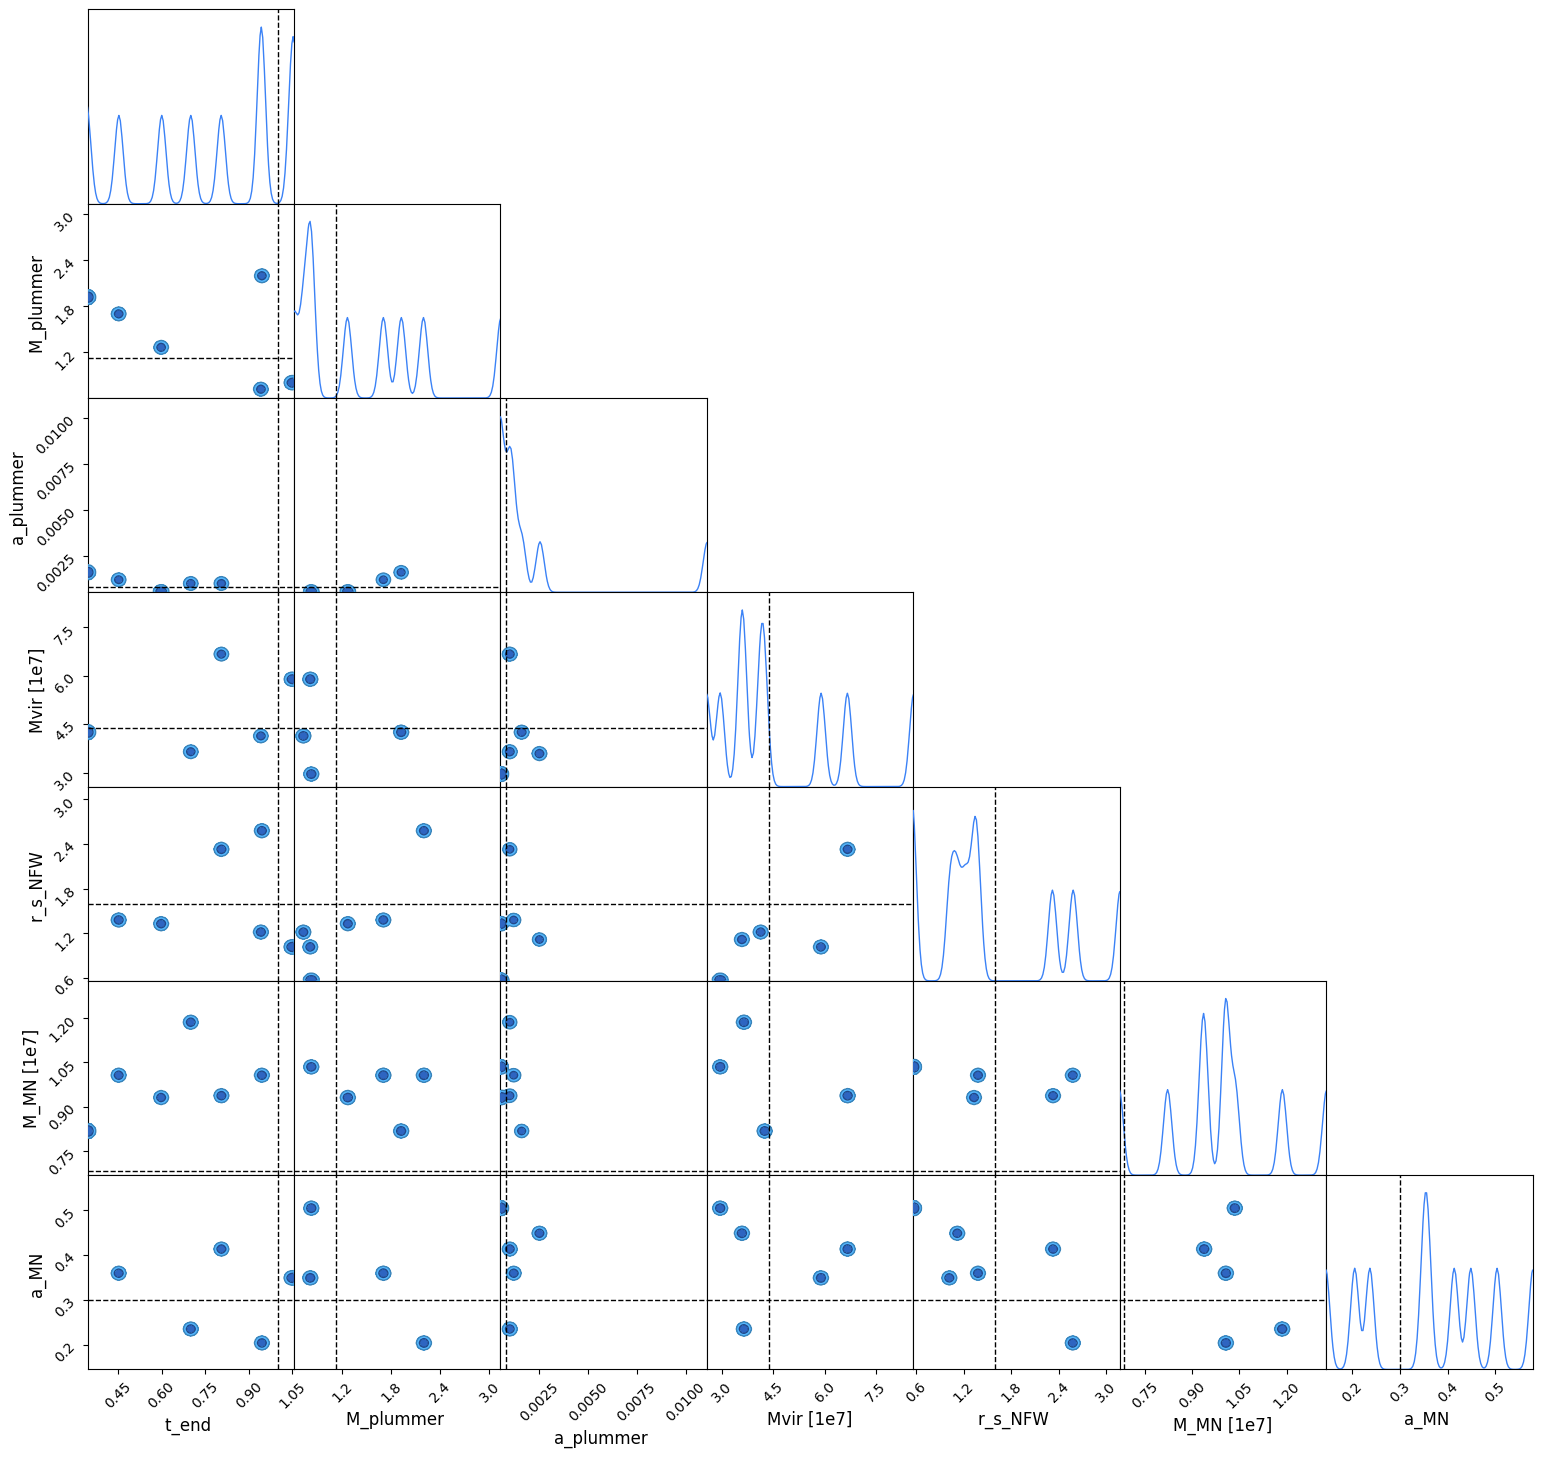

In [37]:
df_sample = pd.DataFrame(samples, columns=['t_end', 'M_plummer', 'a_plummer', 'Mvir', 'r_s_NFW', 'M_MN', 'a_MN'])
c = ChainConsumer()
c.add_chain(Chain(samples=df_sample, name='ScipyMinimize'))
c.add_truth(Truth(location={'t_end': params.t_end,
                           'M_plummer': params.Plummer_params.Mtot,
                           'a_plummer': params.Plummer_params.a,
                           'Mvir': params.NFW_params.Mvir,
                           'r_s_NFW': params.NFW_params.r_s,
                           'M_MN': params.MN_params.M,
                           'a_MN': params.MN_params.a,}))
fig = c.plotter.plot()

# We try with LBFGS because its vmappable but too costly to go with more then batch_size=1

In [10]:
parameter_value = jax.random.uniform(key=key, 
                                    shape=(10, 7), 
                                    minval=jnp.array([0.5 * u.Gyr.to(code_units.code_time), # t_end in Gyr
                                                    10**3.0 * u.Msun.to(code_units.code_mass), # Plummer mass
                                                    params.Plummer_params.a*(1/4),
                                                    params.NFW_params.Mvir*(1/4),
                                                    params.NFW_params.r_s*(1/4), 
                                                    params.MN_params.M*(1/4), 
                                                    params.MN_params.a*(1/4),]), 
                                                    
                                    maxval=jnp.array([5 * u.Gyr.to(code_units.code_time), # t_end in Gyr
                                                    10**4.5 * u.Msun.to(code_units.code_mass), #Plummer mass
                                                    params.Plummer_params.a*(8/4),
                                                    params.NFW_params.Mvir*(8/4), 
                                                    params.NFW_params.r_s*(8/4), 
                                                    params.MN_params.M*(8/4), 
                                                    params.MN_params.a*(8/4),])) 

In [ ]:
optimizer_lbfgs = LBFGS(
    fun=time_integration_fix_position_grad_ScipyMinimize, 
    # value_and_grad=False, # Set to True if your fun returns (value, grad), otherwise False (default)
    tol=1e-6, # Example: tolerance for gradient norm squared, adjust as needed
    # maxiter=500, # Example: maximum iterations, adjust as needed
    # history_size=10, # Default for LBFGS history
    # jit=True # fun is already JITted, but LBFGS can JIT its own loop
)

@jit
def run_single_optimization(initial_params_for_run, key_for_run):
    # init_params_for_run will be a slice from parameter_value, e.g., shape (7,)
    # key_for_run will be a single JAX key, e.g., shape (2,)
    sol = optimizer_lbfgs.run(init_params=initial_params_for_run, key=key_for_run)
    return sol # or sol.params, sol.state.fun_val, etc., depending on what you want to collect

# vmapped_optimizer_run = jax.lax(run_single_optimization, in_axes=(0, 0), out_axes=0)
# Execute the vmapped optimizations
# solutions = vmapped_optimizer_run(parameter_value, random.split(key, parameter_value.shape[0]))

@jit
def run_single_optimization_laxmap(input, ):
    # init_params_for_run will be a slice from parameter_value, e.g., shape (7,)
    # key_for_run will be a single JAX key, e.g., shape (2,)
    initial_params_for_run, key_for_run = input
    sol = optimizer_lbfgs.run(init_params=initial_params_for_run, key=key_for_run)
    return sol # or sol.params, sol.state.fun_val, etc., depending on what you want to collect


# laxmap_optimizer_run = jax.lax.map(run_single_optimization_laxmap, (parameter_value, random.split(key, parameter_value.shape[0])), batch_size=1)

@jit
def run_single_optimization_forloop(_, input, ):
    # init_params_for_run will be a slice from parameter_value, e.g., shape (7,)
    # key_for_run will be a single JAX key, e.g., shape (2,)
    initial_params_for_run, key_for_run = input[_]
    sol = optimizer_lbfgs.run(init_params=initial_params_for_run, key=key_for_run)
    return sol # or sol.params, sol.state.fun_val, etc., depending on what you want to collect


@jit
def run_single_optimization_scan(_, input, ):
    # init_params_for_run will be a slice from parameter_value, e.g., shape (7,)
    # key_for_run will be a single JAX key, e.g., shape (2,)
    initial_params_for_run, key_for_run = input[:7], input[7:]
    # key = jax.random.PRNGKey(key_for_run[0])
    sol = optimizer_lbfgs.run(init_params=initial_params_for_run, key=jnp.uint32(key_for_run))
    return jnp.concatenate((sol.params, key), axis=0), jnp.concatenate((sol.params, key), axis=0) # or sol.params, sol.state.fun_val, etc., depending on what you want to collect

par_0 = parameter_value[0]  # Reshape to (1, 7)
key_0 = jax.random.split(key, parameter_value.shape[0])[0] # Reshape to (1, 2)

par_ = parameter_value[1:]  # Reshape to (9, 7)
key_ = jax.random.split(key, parameter_value.shape[0])[1:]  # Reshape to (9, 2)


for_loop_optimizer_run = jax.lax.scan(run_single_optimization_scan,
                                      init= jnp.concatenate((par_0, key_0)),
                                      xs = jnp.concatenate((par_, key_), axis=1 ) ) 

2025-06-09 15:01:57.469942: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3022] Can't reduce memory use below 28.06GiB (30128252773 bytes) by rematerialization; only reduced to 31.30GiB (33608323978 bytes), down from 31.30GiB (33608323978 bytes) originally


In [ ]:
#plotting

samples = np.array([sol.params for sol in solutions])
df_sample = pd.DataFrame(samples, columns=['t_end', 'M_plummer', 'a_plummer', 'Mvir', 'r_s_NFW', 'M_MN', 'a_MN'])
c = ChainConsumer()
c.add_chain(Chain(samples=df_sample, name='ScipyMinimize'))
c.add_truth(Truth(location={'t_end': params.t_end,
                           'M_plummer': params.Plummer_params.Mtot,
                           'a_plummer': params.Plummer_params.a,
                           'Mvir': params.NFW_params.Mvir,
                           'r_s_NFW': params.NFW_params.r_s,
                           'M_MN': params.MN_params.M,
                           'a_MN': params.MN_params.a,}))
fig = c.plotter.plot()

# Gradient descend

Lighter then LBFGS but still not possible to go beyong batch_size=1, so for loop is still needed without multiple GPU

In [ ]:
@jit
def time_integration_fix_position_grad_ScipyMinimize(param, key):
    t_end, M_plummer, a_plummer, Mvir, r_s_NFW, M_MN, a_MN = param
    return time_integration_fix_position_grad(t_end, 
                                              M_plummer,
                                              a_plummer,
                                              Mvir,
                                              r_s_NFW,
                                              M_MN,
                                              a_MN,
                                              key)


In [8]:
parameter_value = jax.random.uniform(key=key, 
                                    shape=(2, 7), 
                                    minval=jnp.array([0.5 * u.Gyr.to(code_units.code_time), # t_end in Gyr
                                                    10**3.0 * u.Msun.to(code_units.code_mass), # Plummer mass
                                                    params.Plummer_params.a*(1/4),
                                                    params.NFW_params.Mvir*(1/4),
                                                    params.NFW_params.r_s*(1/4), 
                                                    params.MN_params.M*(1/4), 
                                                    params.MN_params.a*(1/4),]), 
                                                    
                                    maxval=jnp.array([5 * u.Gyr.to(code_units.code_time), # t_end in Gyr
                                                    10**4.5 * u.Msun.to(code_units.code_mass), #Plummer mass
                                                    params.Plummer_params.a*(8/4),
                                                    params.NFW_params.Mvir*(8/4), 
                                                    params.NFW_params.r_s*(8/4), 
                                                    params.MN_params.M*(8/4), 
                                                    params.MN_params.a*(8/4),])) 

In [9]:
# We pick gradient descent for pedagogical and visualization reasons.
# In practice one would use e.g. Levenberg-Marquardt from the
# optimistix package.

from functools import partial
@partial(jit, static_argnames=('func','learning_rate', 'tol', 'max_iter'))
def gradient_descent_optimization(func, x_init, key, learning_rate=20, tol=0.5, max_iter=2000):
    # xlist = []
    xlist = jnp.zeros((max_iter + 1, x_init.shape[0]))
    x = x_init
    # loss_list = []
    loss_list = jnp.zeros(max_iter + 1)

    # xlist.append(x)
    xlist = xlist.at[0].set(x)  # Initialize the first element with x_init

    optimizer = optax.adam(learning_rate=learning_rate)
    optimizer_state = optimizer.init(x)

    for _ in range(max_iter):
        # Compute the function value and its gradient
        loss, f_grad = jax.value_and_grad(func)(x, key)
        # loss_list.append(loss)
        loss_list = loss_list.at[_].set(loss)
        
        # Update the parameter
        updates, optimizer_state = optimizer.update(f_grad, optimizer_state)
        x = optax.apply_updates(x, updates)
        key = random.split(key, 1)[0]  # Update the key for the next iteration
        # xlist.append(x)
        xlist = xlist.at[_ + 1].set(x)
        
        # Check convergence
        if jnp.linalg.norm(updates) < tol:
            break
    
    return x, xlist, loss_list

In [10]:
from functools import partial
import jax.lax

@partial(jit, static_argnames=('func', 'learning_rate', 'tol', 'max_iter'))
def gradient_descent_optimization_while(func, x_init, key, learning_rate=20, tol=0.5, max_iter=2000):
    optimizer = optax.adam(learning_rate=learning_rate)

    # Initial state for the loop: (x, opt_state, current_key, iteration, loss_history_list, x_history_list)
    # Using lists for history here as while_loop makes dynamic sizing harder for JIT.
    # For JIT compatibility with history, it's often better to run the loop and then process history,
    # or use fori_loop with pre-allocated arrays if max_iter is acceptable.
    # For simplicity in this example, we'll collect history outside JIT or accept fixed size.
    # Let's stick to pre-allocated for JIT-friendliness of history.

    initial_loss_hist = jnp.zeros(max_iter)
    initial_x_hist = jnp.zeros((max_iter + 1, x_init.shape[0])).at[0].set(x_init)

    initial_val = (
        x_init,
        optimizer.init(x_init),
        key,
        0, # current iteration
        initial_loss_hist,
        initial_x_hist,
        False # dummy for converged check in cond_fun for first iteration
    )

    def cond_fun(val):
        _, _, _, i, _, _, converged_in_prev_step = val
        # Continue if not converged AND iterations < max_iter
        return jnp.logical_and(i < max_iter, jnp.logical_not(converged_in_prev_step))

    def body_fun(val):
        x, opt_state, current_key, i, loss_hist, x_hist, _ = val
        
        iter_key, next_key_for_loop = random.split(current_key)
        
        loss, f_grad = jax.value_and_grad(func)(x, iter_key)
        updates, new_opt_state = optimizer.update(f_grad, opt_state)
        new_x = optax.apply_updates(x, updates)
        
        converged_this_iteration = jnp.linalg.norm(updates) < tol
        
        updated_loss_hist = loss_hist.at[i].set(loss)
        updated_x_hist = x_hist.at[i + 1].set(new_x)
        
        return (new_x, new_opt_state, next_key_for_loop, i + 1, updated_loss_hist, updated_x_hist, converged_this_iteration)

    final_x, _, _, num_iters, loss_list_filled, xlist_filled, _ = jax.lax.while_loop(cond_fun, body_fun, initial_val)
    
    # Slice the history arrays to the actual number of iterations
    # This slicing part itself is not JIT-friendly if num_iters is a tracer.
    # So, typically, you'd return num_iters and do the slicing outside the JITted function.
    # For now, we return the filled arrays.
    
    return final_x, xlist_filled, loss_list_filled #, num_iters (can be returned to slice outside)

# When calling, you might want to use the fori_loop version first as it's often simpler to get right.
# initial_guess = parameter_value[0]
# final_params, xlist, loss_list = gradient_descent_optimization_while( # or gradient_descent_optimization
# func=time_integration_fix_position_grad_ScipyMinimize,
# x_init=initial_guess,
# key = key,
# learning_rate=0.01,
# tol=1e-2,
# max_iter=100
# )

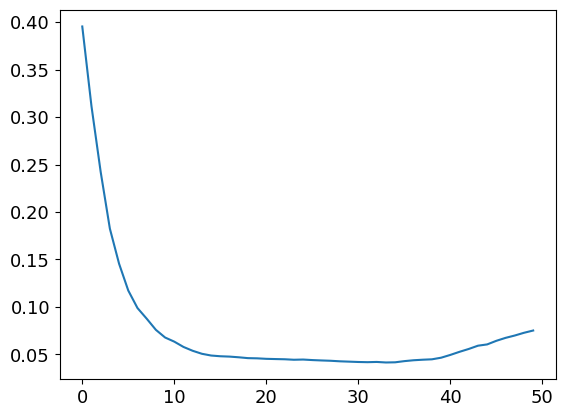

In [11]:
initial_guess = parameter_value[0]
final_params, xlist, loss_list = gradient_descent_optimization_while(
    func=time_integration_fix_position_grad_ScipyMinimize,
    x_init=initial_guess,
    key = key,
    learning_rate=0.01,
    tol=1e-3,
    max_iter=50
)

plt.plot(loss_list, label='Loss')

In [ ]:
sol = jax.vmap(lambda initial_guess, key: gradient_descent_optimization_while(
    func=time_integration_fix_position_grad_ScipyMinimize,
    x_init=initial_guess,
    key=key,
    learning_rate=0.01,
    tol=1e-2,
    max_iter=100
))(parameter_value, random.split(key, parameter_value.shape[0]))

2025-06-12 21:31:24.053281: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3022] Can't reduce memory use below 28.06GiB (30128241639 bytes) by rematerialization; only reduced to 31.05GiB (33341130391 bytes), down from 31.91GiB (34262956527 bytes) originally
2025-06-12 21:31:51.322135: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 31.37GiB (rounded to 33686461696)requested by op 
2025-06-12 21:31:51.322505: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] *___________________________________________________________________________________________________
E0612 21:31:51.322532 3827565 pjrt_stream_executor_client.cc:2917] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 33686461536 bytes. [tf-allocator-allocation-error='']


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 33686461536 bytes.

In [ ]:
def laxmapgradient_descent_optimization(intial_guess_key):
    initial_guess, key = intial_guess_key
    return gradient_descent_optimization_while(
        func=time_integration_fix_position_grad_ScipyMinimize,
        x_init=initial_guess,
        key=key,
        learning_rate=0.01,
        tol=1e-3,
        max_iter=10
    )

sol = jax.lax.map(laxmapgradient_descent_optimization, (parameter_value, random.split(key, parameter_value.shape[0])), batch_size=4)  

2025-06-12 21:42:06.216549: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3022] Can't reduce memory use below 28.06GiB (30128252583 bytes) by rematerialization; only reduced to 31.05GiB (33341117431 bytes), down from 31.91GiB (34262943567 bytes) originally
2025-06-12 21:42:32.988530: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 31.37GiB (rounded to 33686459904)requested by op 
2025-06-12 21:42:32.988743: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] *___________________________________________________________________________________________________
E0612 21:42:32.988763 3853618 pjrt_stream_executor_client.cc:2917] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 33686459872 bytes. [tf-allocator-allocation-error='']


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 33686459872 bytes.